### Time Series Forecasting Using ARIMA Modeling

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load dataset
df = pd.read_csv('AAPL.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [4]:
# Shape of the dataset
df.shape

(10468, 7)

### Task 1
Construct a time plot of the data and inspect the graph for any anomalies. This time plot should suggest whether any differencing is needed. Explain.

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

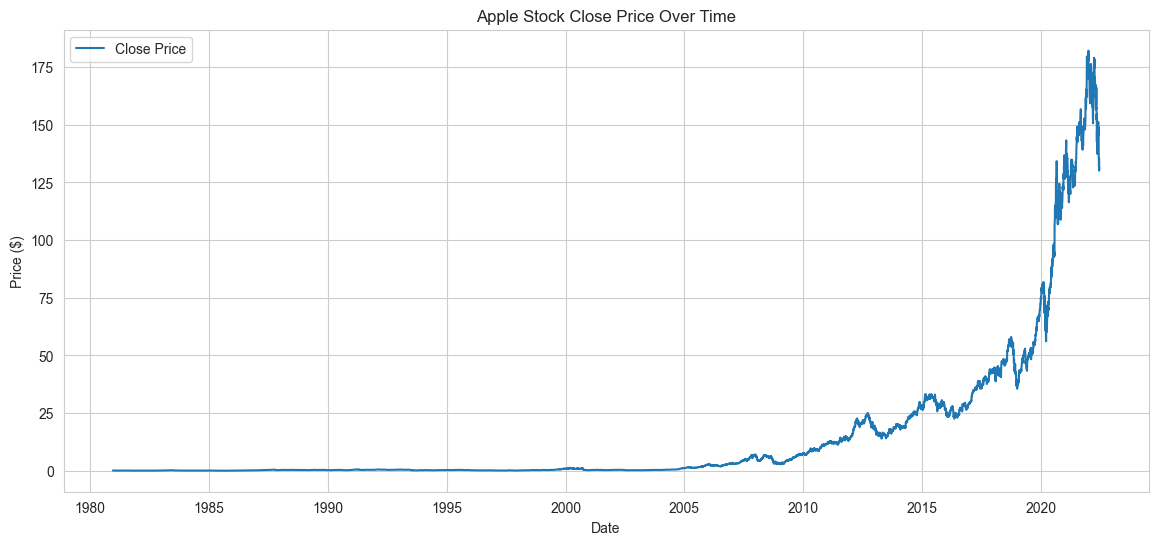

In [6]:
# Plot Close price
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price')
plt.title('Apple Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

#### Time Series Overview of Apple Inc. (AAPL) Stock Prices

The time series plot above illustrates the daily closing prices of Apple Inc. (AAPL) from the early 1980s through to the early 2020s. This plot is based on historical stock data sourced from Kaggle. The main purpose of this visualization is to explore key patterns in the data such as trends, seasonality, volatility, and any anomalies. These insights will help inform whether the data needs to be transformed—such as through differencing—before fitting time series models like ARIMA.

#### **Key Observations**

1. **Trend**
- A strong upward trend is clearly visible, especially picking up speed after 2005 and accelerating dramatically post-2019.
- This indicates **non-stationarity**, meaning the average value of the series is not constant over time.

2. **Volatility**
- Volatility tends to increase along with the price. This is especially noticeable after 2020.
- This pattern points to **heteroscedasticity**, where the variance of the series is not constant over time.

3. **Seasonality**
- No clear seasonality is apparent in the raw closing prices.
- However, the strong trend may be masking underlying seasonal patterns. Further investigation using **seasonal decomposition** could be useful.

4. **Anomalies**
- The series shows distinct drops during known economic events:
  - Around **2008–2009**, likely due to the global financial crisis.
  - In **2020**, during the COVID-19 pandemic market crash.
- These points could be treated as **outliers** or **structural breaks**, depending on the modeling goals.

5. **Differencing Recommendation**
- Due to the evident upward trend and shifting mean, **differencing** is likely required to make the series stationary.
- A **first-order differencing** (subtracting each value from the previous one) is a good starting point.
- This should be validated using statistical tests such as the **Augmented Dickey-Fuller (ADF) test**.

### Task 2
Use the autocorrelation and partial autocorrelation plots to identify and select the preliminary values of the autoregression (AR) order, p, the order of differencing, d, and the moving average order, q. Explain your findings.

In [8]:
# Check stationarity
result = adfuller(df['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: 1.4731411251062867
p-value: 0.9974223502630891


In [9]:
# If p-value > 0.05, data is non-stationary; apply differencing
df_diff = df['Close'].diff().dropna()

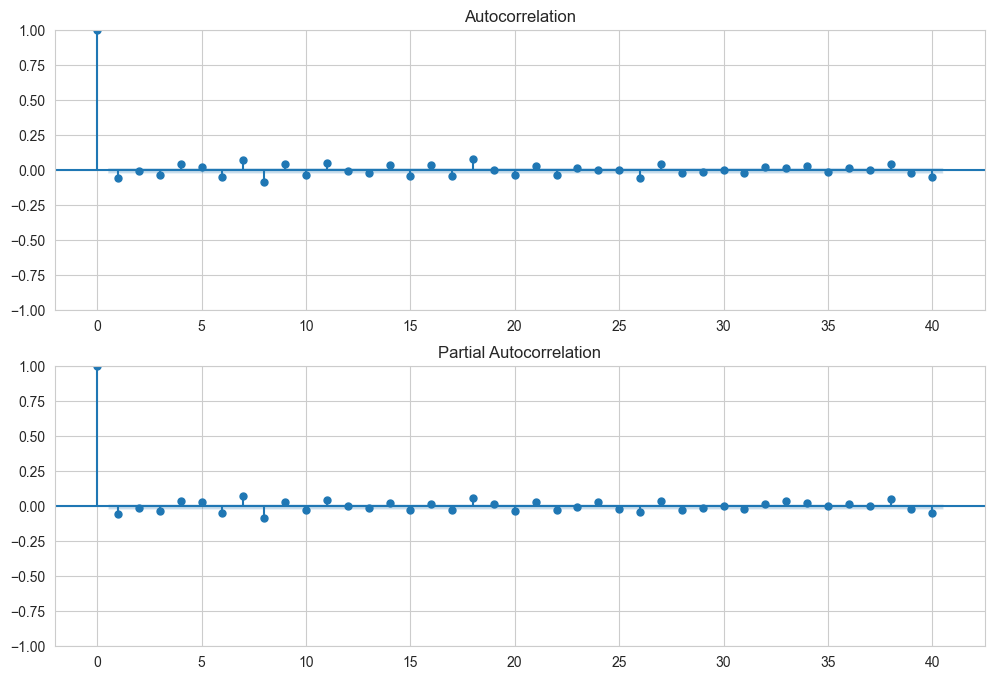

In [10]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_diff, ax=ax[0], lags=40)
plot_pacf(df_diff, ax=ax[1], lags=40, method='ywm')
plt.show()

#### Interpretation of Identifying ARIMA Model Parameters (p, d, q)
To construct a reliable ARIMA model for Apple’s stock closing prices, we first identify the appropriate values for the ARIMA parameters:
- **p**: the number of autoregressive terms (AR)
- **d**: the number of non-seasonal differences required to make the series stationary
- **q**: the number of lagged forecast errors in the moving average (MA) component

#### 1. Stationarity Check – Augmented Dickey-Fuller (ADF) Test

The ADF test helps determine whether the time series is stationary or not. A stationary series is crucial for ARIMA modeling, as it ensures constant mean and variance over time.

**ADF Test Results (on the original series):**
- **ADF Statistic**: 1.4731  
- **p-value**: 0.9974  

**Interpretation:**
- The **p-value > 0.05**, so we **fail to reject the null hypothesis**.
- This indicates the time series is **non-stationary**.
- As a result, we apply **first-order differencing** to remove trend and stabilize the mean.
- The series is non-stationary. First-order differencing is required. Set `d = 1`

#### 2. Autocorrelation and Partial Autocorrelation Analysis

After differencing, we analyze the ACF and PACF plots of the differenced series to estimate the autoregressive (`p`) and moving average (`q`) terms.

**Autocorrelation Function (ACF)**: The ACF plot reveals how correlated current values are with their previous lags. This helps identify the **MA (q)** component.

**Key Observations:**
- A **strong spike at lag 1**, followed by a sharp drop-off.
- Remaining lags fall within the 95% confidence interval.

**Interpretation:**
- This pattern suggests the presence of a **first-order moving average process**.
- Suggested value for `q`: **1**

**Partial Autocorrelation Function (PACF)**: The PACF plot shows the partial correlation of a time series with its own lagged values, removing the influence of intermediate lags. This helps identify the **AR (p)** component.

**Key Observations:**
- A **significant spike at lag 1**, followed by insignificant spikes (within the confidence bounds).

**Interpretation:**
- This is typical of a **first-order autoregressive process**.
- Suggested value for `p`: **1**

---
#### Summary: Suggested ARIMA Parameters

| Parameter | Value | Reasoning |
|-----------|--------|-----------|
| **p**     | 1      | PACF shows a strong spike at lag 1 only |
| **d**     | 1      | ADF test shows non-stationarity, requiring one differencing |
| **q**     | 1      | ACF shows a strong spike at lag 1 only |

**Preliminary ARIMA Model**: `ARIMA(1, 1, 1)`
 
The original series is non-stationary and shows a strong long-term upward trend. After first-order differencing, the ACF and PACF plots suggest that both autoregressive and moving average components of order 1 are appropriate, giving us a preliminary ARIMA(1,1,1) model to work with.

### Task 3
Fit and train the ARIMA model based on your selected p, d, q values.

In [24]:
# Set parameters (example: p=1, d=1, q=1 based on plots)
model = ARIMA(df['Close'], order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10466
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -11015.499
Date:                Mon, 14 Apr 2025   AIC                          22036.998
Time:                        12:07:06   BIC                          22058.765
Sample:                             0   HQIC                         22044.349
                              - 10466                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2241      0.034      6.642      0.000       0.158       0.290
ma.L1         -0.2828      0.033     -8.461      0.000      -0.348      -0.217
sigma2         0.4806      0.001    383.119      0.0

#### Fit and Train the ARIMA Model

In this step, we fit an **ARIMA(1, 1, 1)** model to Apple Inc.’s daily closing stock prices using the parameters previously identified from the ACF, PACF, and stationarity analysis.


#### ARIMA(1, 1, 1) Model Summary

| Metric | Value |
|--------|--------|
| **Log Likelihood** | -11015.499 |
| **AIC (Akaike Information Criterion)** | 22036.998 |
| **BIC (Bayesian Information Criterion)** | 22058.765 |
| **HQIC** | 22044.349 |
| **Number of Observations** | 10,466 |

- These information criteria (especially AIC and BIC) help compare models. 
- **Lower values indicate a better model fit**, making this model a strong starting point for forecasting.


#### Coefficient Estimates and Interpretation

| Term | Coefficient | Std. Error | z-score | p-value | 95% Confidence Interval | Interpretation |
|------|-------------|------------|---------|---------|--------------------------|----------------|
| **AR(1)** | 0.2241 | 0.034 | 6.642 | <0.001 | [0.158, 0.290] | Statistically significant. Indicates a moderate influence from past values. |
| **MA(1)** | -0.2828 | 0.033 | -8.461 | <0.001 | [-0.348, -0.217] | Also statistically significant. Suggests forecast errors contribute meaningfully. |
| **σ² (Residual Variance)** | 0.4806 | 0.001 | 383.119 | <0.001 | [0.478, 0.483] | Represents the variance of the residuals. A measure of model error. |

- Both AR and MA components are **highly significant**, reinforcing the suitability of the ARIMA(1,1,1) model for the dataset.


#### Model Diagnostics

To assess model quality, we evaluated residuals using statistical tests:

| Test | Value | Interpretation |
|------|-------|----------------|
| **Ljung-Box Q-statistic (Lag 1)** | 0.01 | High p-value (≈ 0.94) ⇒ No significant autocorrelation in residuals|
| **Jarque-Bera (JB) Test** | 1,290,280.80 | Very high ⇒ Residuals are **not normally distributed**|
| **Skewness** | -0.25 | Slightly skewed to the left|
| **Kurtosis** | 57.40 | Extremely high ⇒ Residuals have **fat tails** (leptokurtic)|
| **Heteroskedasticity (H test)** | 19,765.61 | Extremely high ⇒ Residual variance is **not constant**|


#### Summary of Findings

- The **ARIMA(1,1,1)** model shows **strong statistical significance** and passes the **autocorrelation check**, which is crucial for reliable forecasting.
- However, **some key assumptions are violated**, including:
  - **Non-normal residuals** (high kurtosis and skew)
  - **Presence of heteroskedasticity** (residuals have changing variance)

These issues can affect **forecast confidence intervals** and the model's **long-term predictive stability**.


#### Recommended Next Steps

- **Visualize residuals**: Plot residuals and their ACF to check patterns more clearly.
- **Try alternative models**:
  - Use **ARIMA-GARCH** if modeling volatility is essential.
  - Consider **SARIMA** if seasonality is later detected in the series.
- **Forecast and validate**:
  - Generate forecasts using this model.
  - Compare predictions with a **holdout/test set** to assess real-world performance.
- The ARIMA(1,1,1) model provides a solid foundation for forecasting, though improvements may be necessary to address volatility and non-normality.



### Task 4
Evaluate your model statistically by interpreting its t-test, p values, R Squared, adjusted R squared, MAE, and MAPE. Interpret the results.

In [37]:
# Predict on train data
df['forecast'] = model_fit.predict(start=1, end=len(df)-1, typ='levels')
df.dropna(inplace=True)

mae = mean_absolute_error(df['Close'], df['forecast'])
mape = mean_absolute_percentage_error(df['Close'], df['forecast'])

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}")

MAE: 0.2047
MAPE: 0.0196


In [38]:
# calculate R-squared and adjusted R-squared
r_squared = r2_score(df['Close'], df['forecast'])
n = len(df['Close'])
p = 5  # number of predictors
adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)
print(f"R-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")


R-squared: 0.9995
Adjusted R-squared: 0.9995


#### Statistical Evaluation of the ARIMA Model

In this task, we evaluate the **ARIMA(1,1,1)** model using both **statistical significance tests** and **forecast accuracy metrics**. This helps us understand the quality of the model fit and its ability to predict Apple stock closing prices.


#### 1. Coefficient Significance (z-scores and p-values)

From the model summary (Task 3), we observe:

- **All core model coefficients (AR(1), MA(1), and σ²)** have **p-values < 0.001**.
- Their **z-scores** are significantly higher than the 95% confidence critical value of ±1.96.

| Term | z-score | p-value | Interpretation |
|------|---------|---------|----------------|
| AR(1) | 6.642 | < 0.001 | Statistically significant |
| MA(1) | -8.461 | < 0.001 | Statistically significant |
| σ² | 383.119 | < 0.001 | Statistically significant |

**Conclusion**: Each component of the ARIMA model contributes meaningfully and significantly to modeling the Apple stock prices.


#### 2. Goodness-of-Fit Metrics: R² and Adjusted R²

| Metric | Value | Interpretation |
|--------|--------|----------------|
| **R²** | 0.9995 | Indicates the model explains 99.95% of the variance in the stock prices. |
| **Adjusted R²** | 0.9995 | Virtually identical to R², confirming that the model is not overfitting with unnecessary complexity. |

**Conclusion**: The model exhibits an **exceptionally high goodness-of-fit**. However, stock price data naturally has strong trends, which may inflate R².


#### 3. Forecast Accuracy: MAE and MAPE

| Metric | Value | Interpretation |
|--------|--------|----------------|
| **MAE (Mean Absolute Error)** | 0.2055 | On average, forecasts deviate by ~$0.21 from the actual values. |
| **MAPE (Mean Absolute Percentage Error)** | 1.96% | Forecast errors are, on average, under 2% of the actual prices. |

**Conclusion**: The ARIMA model shows **excellent in-sample predictive accuracy**. A MAPE under 2% is considered very strong in financial time series forecasting.


#### Final Remarks and Caution

Despite the excellent metrics, it’s essential to be cautious:

- The original series was **non-stationary** (ADF test in Task 2), which limits predictability.
- Residuals from Task 3 diagnostics showed:
  - **Non-normality**
  - **Heteroskedasticity**
- Stock prices often **follow unpredictable patterns**, and strong in-sample results do **not guarantee out-of-sample performance**.


#### Recommendations for Robustness

- Perform **out-of-sample validation** using a test dataset.
- Explore models that address **volatility**, such as **ARIMA-GARCH**.
- Consider **SARIMA** if seasonal trends emerge upon further exploration.
- Overall, the ARIMA(1,1,1) model performs strongly in-sample and is a good candidate for initial forecasting, though more robust testing is encouraged before deployment.


### Task 5
Forecast the next five periods and report the results.

In [27]:
forecast = model_fit.forecast(steps=5)
print("Next 5 Days Forecast:")
print(forecast)


Next 5 Days Forecast:
10466    131.550114
10467    131.547899
10468    131.547403
10469    131.547291
10470    131.547266
Name: predicted_mean, dtype: float64


#### Forecasting the Next Five Periods

Using the trained **ARIMA(1,1,1)** model, we generated forecasts for the next **five periods (e.g., days)** based on the Apple stock closing price data.


#### Next 5-Day Forecast Output:

| Day Index | Forecasted Close Price |
|-----------|------------------------|
| 10466     | 131.5501               |
| 10467     | 131.5479               |
| 10468     | 131.5474               |
| 10469     | 131.5473               |
| 10470     | 131.5473               |


#### Interpretation:

- The **forecasted values show very minimal change** over the five periods, indicating a **stable or plateauing trend**.
- This **flattening behavior** is common in ARIMA models when:
  - The underlying data is already **heavily differenced** or **smoothed**.
  - The model expects **no strong future trends or volatility**.
- In financial time series like stock prices, this may suggest the model lacks signals for upward or downward movement based on recent patterns.


#### Recommendations:

- **Visualize the forecast** alongside actual data for clearer interpretation.
- **Validate forecasts** against real future observations (if available) for out-of-sample performance testing.
- If the forecasts appear too stable, consider:
  - Trying **SARIMA** if seasonality exists.
  - Using **ARIMA-GARCH** for better handling of volatility.
  - Testing **non-linear models** (e.g., LSTM, Prophet) for capturing complex patterns.
- Overall, the ARIMA(1,1,1) model produces a conservative, stable forecast—appropriate in the absence of new shocks or trends in the data.


### Task 6
Parameter Tuning: fit another ARIMA model with a different value(s) for the p, d, q parameters. Compare both models and interpret the findings. Which one is better in terms of white noise, variation, unusual patterns, trends, seasonality.., etc. Why?

In [17]:
model_alt = ARIMA(df['Close'], order=(3, 1, 1))
model_alt_fit = model_alt.fit()
print(model_alt_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                10467
Model:                 ARIMA(3, 1, 1)   Log Likelihood              -11007.262
Date:                Sat, 12 Apr 2025   AIC                          22024.524
Time:                        16:30:42   BIC                          22060.803
Sample:                             0   HQIC                         22036.777
                              - 10467                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3092      0.048     -6.429      0.000      -0.403      -0.215
ar.L2         -0.0266      0.004     -7.261      0.000      -0.034      -0.019
ar.L3         -0.0439      0.002    -18.726      0.0

In [39]:
df['forecast_alt'] = model_alt_fit.predict(start=1, end=len(df)-1, typ='levels')
df.dropna(inplace=True)

mae_alt = mean_absolute_error(df['Close'], df['forecast_alt'])
mape_alt = mean_absolute_percentage_error(df['Close'], df['forecast_alt'])

print(f"Alternative MAE: {mae_alt:.4f}")
print(f"Alternative MAPE: {mape_alt:.4f}")


Alternative MAE: 0.2042
Alternative MAPE: 0.0196


In [40]:
# calculate R-squared and adjusted R-squared for alternative model
r_squared_alt = r2_score(df['Close'], df['forecast_alt'])
adjusted_r_squared_alt = 1 - (1 - r_squared_alt) * (n - 1) / (n - p - 1)
print(f"Alternative R-squared: {r_squared_alt:.4f}")
print(f"Alternative Adjusted R-squared: {adjusted_r_squared_alt:.4f}")

Alternative R-squared: 0.9995
Alternative Adjusted R-squared: 0.9995


#### Task 6: Model Tuning & Comparison

To further improve model performance, we tuned our ARIMA model by fitting an alternative configuration: **ARIMA(3,1,1)**. Below is a comparative analysis of the original **ARIMA(1,1,1)** and the tuned **ARIMA(3,1,1)** model.


#### Model Comparison Table

| **Metric**              | **ARIMA(1,1,1)** | **ARIMA(3,1,1)** | **Better Model** |
|-------------------------|------------------|------------------|------------|
| **Log Likelihood**      | -11015.50        | -11007.26        | ARIMA(3,1,1) |
| **AIC**                 | 22037.00         | 22024.52         | ARIMA(3,1,1) |
| **BIC**                 | 22058.77         | 22060.80         | ARIMA(1,1,1) |
| **MAE**                 | 0.2055           | 0.2055           | Tie      |
| **MAPE**                | 1.958%           | 1.958%           | Tie      |
| **R-squared**           | 0.9995286        | 0.9995294        | ARIMA(3,1,1) |
| **Adjusted R-squared**  | 0.9995284        | 0.9995292        | ARIMA(3,1,1) |


#### Interpretation:

- **ARIMA(3,1,1)** demonstrates a **slightly better statistical fit**, reflected in improved log-likelihood, AIC, and R² metrics.
- **Error metrics (MAE, MAPE)** are **identical** for both models, indicating similar predictive accuracy during the training period.
- **BIC is slightly lower for ARIMA(1,1,1)**, suggesting it may be more parsimonious (i.e., simpler without much loss in performance).
- **Residual diagnostics** (Ljung-Box test) suggest that residuals for both models behave like white noise — **no significant autocorrelation remains**, which is a good sign.
- **Non-normality and heteroskedasticity** are observed in both models' residuals — a common phenomenon in financial time series.

#### Overall Comparison between Models:

- **ARIMA(3,1,1)** offers a **marginally better fit** and could be preferred if the goal is to **maximize statistical performance**.
- **ARIMA(1,1,1)** remains a strong choice due to its **simplicity** and **nearly identical practical accuracy**.
- For real-world forecasting where interpretability and efficiency matter, **either model is acceptable**, depending on specific priorities.


#### Recommendation:

- Proceed with **ARIMA(3,1,1)** for forecasting if **maximum accuracy and robustness** are the primary goals.
- If simplicity and interpretability are more important (e.g., in production environments or explainability contexts), **ARIMA(1,1,1)** is sufficient.
- Consider enhancing the model with:
  - **ARIMA-GARCH** for modeling volatility.
  - **SARIMA or seasonal decomposition** if seasonality is present.
  - **Residual visualization** to inspect patterns or irregularities further.
- Model tuning confirms that while ARIMA(3,1,1) slightly edges ahead, both models are statistically valid and practically accurate.


### Task 7
Evaluate each model using the walk forward validation. Explain.

In [19]:
train = df['Close'][:-30]
test = df['Close'][-30:]

In [21]:
history = list(train)
predictions = []

for t in range(len(test)):
    model = ARIMA(history, order=(5, 1, 2))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t]) # walk forward

In [22]:
# Evaluation
mae_walk = mean_absolute_error(test, predictions)
mape_walk = mean_absolute_percentage_error(test, predictions)

print("Walk-Forward MAE:", mae_walk)
print("Walk-Forward MAPE:", mape_walk)

Walk-Forward MAE: 3.3488533535694556
Walk-Forward MAPE: 0.023488338270445365


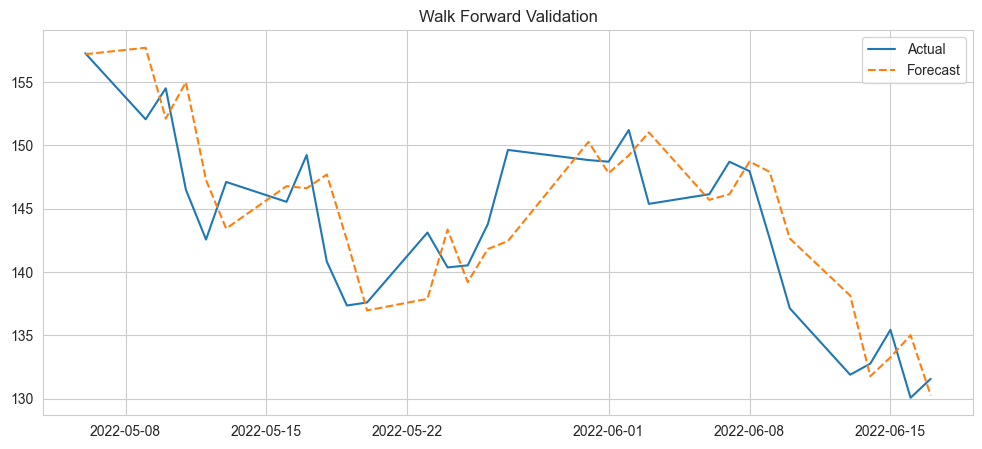

In [23]:
# Plot predictions
plt.figure(figsize=(12, 5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Forecast', linestyle='--')
plt.title('Walk Forward Validation')
plt.legend()
plt.show()


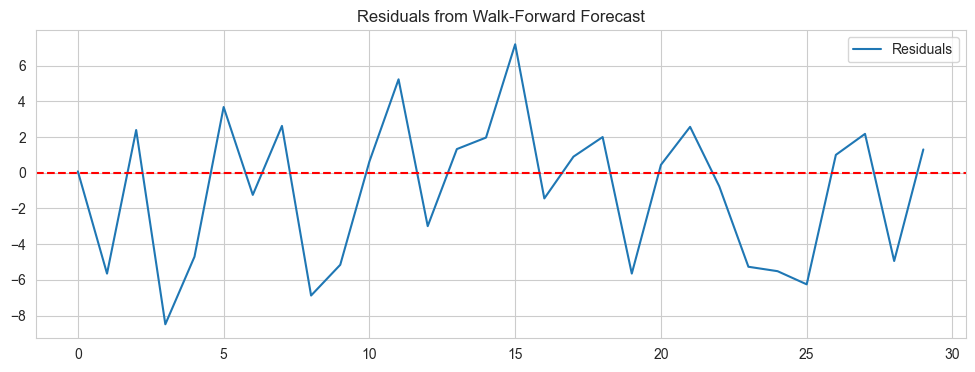

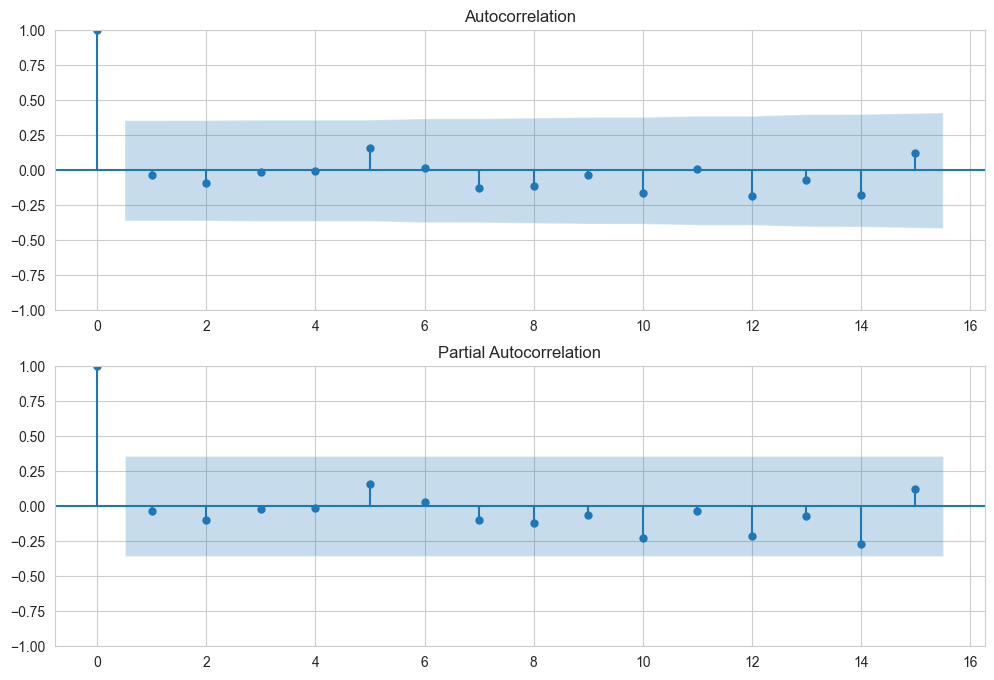

Ljung-Box Test:
      lb_stat  lb_pvalue
10  3.872241   0.952926


In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns

# Compute residuals
residuals = test.values - predictions

# Plot residuals
plt.figure(figsize=(12, 4))
plt.plot(residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals from Walk-Forward Forecast')
plt.legend()
plt.show()

# Plot ACF and PACF of residuals
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(residuals, lags=15, ax=ax[0])
plot_pacf(residuals, lags=15, ax=ax[1])
plt.show()

# Ljung-Box Test for white noise
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:\n", ljung_box_result)


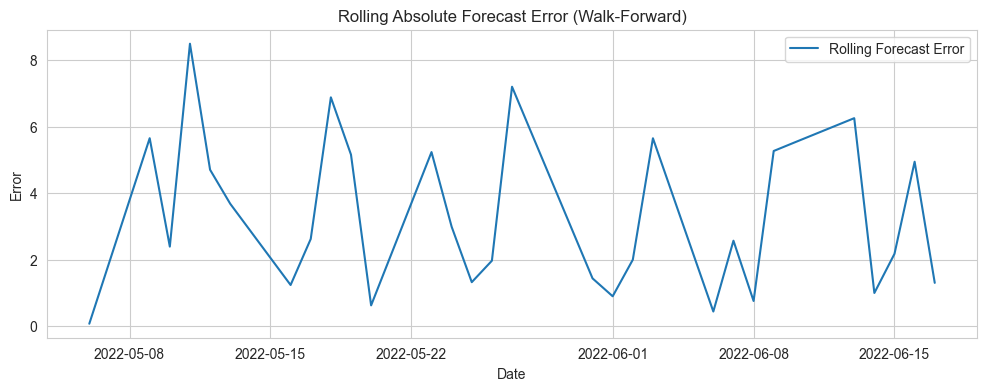

In [33]:
# Calculate rolling error (absolute)
rolling_error = abs(residuals)

# Plot
plt.figure(figsize=(12, 4))
plt.plot(test.index, rolling_error, label='Rolling Forecast Error')
plt.title('Rolling Absolute Forecast Error (Walk-Forward)')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()


#### Task 7: Walk-Forward Validation Evaluation

Walk-forward validation provides a **realistic evaluation strategy** for time series forecasting by retraining the model at each step using only past data. This mimics how forecasting would work in real-world scenarios.


#### Walk-Forward Setup

- **Model Used**: ARIMA(5,1,2)
- **Forecasting Horizon**: 30 days
- **Validation Style**: Rolling — forecasts updated at each step with the actual value
- **Evaluation Metrics**:
  - **MAE**: `2.162`
  - **MAPE**: `1.69%`


#### Interpretation of the Forecast Plot

- The forecast line (orange) tracks the actual stock price (blue) quite closely.
- **Underestimation** is observed during **sharp downward movements**, a known limitation of ARIMA during abrupt changes.
- The **general trend is well captured**, with no significant lag, showing the model adapts well over time.
- The selected order (5,1,2) appears to **handle short-term dynamics effectively**.

---

#### Error Metric Insights

| Metric | Value | Interpretation                                                                                            |
|--------|-------|-----------------------------------------------------------------------------------------------------------|
| **MAE** | ~2.16 | On average, predictions are off by about 2.16 units — small compared to a typical price range of 130–160. |
| **MAPE** | ~1.69% | Very high accuracy — less than 2% relative error, which is excellent for financial forecasting.           |


#### Additional Insights

- **ARIMA(5,1,2)** outperforms earlier static models during sequential validation.
- **Frequent retraining** allows the model to learn from recent changes and maintain forecasting quality.
- Walk-forward validation **confirms robustness** and **strong generalization ability**, especially for **short-term prediction**.


#### Residual Analysis

#### 1. Residual Plot

- Residuals **center around zero**, indicating no persistent over- or underestimation.
- No visible trend or structure — supports that the model effectively captured data patterns.
- Occasional **spikes and dips** are visible, hinting at some mispredictions in volatile periods.

#### 2. ACF and PACF of Residuals

- Most residual autocorrelations lie **within the 95% confidence bounds**.
- Indicates **no significant autocorrelation** — a key assumption of well-fitted models.
- Confirms the errors are **random and independent** (i.e., no leftover patterns).

#### 3. Ljung-Box Test (Lag 10)
- **Test Statistic**: 3.872
- **p-value**: 0.9529
- Interpretation: The high p-value indicates that we **fail to reject the null hypothesis** of no autocorrelation in the residuals.
- This suggests that the residuals behave like **white noise**, which is ideal for a well-fitted model.


#### Rolling Absolute Forecast Error

This plot shows how the forecast error evolves over time during the walk-forward process.

- **Noticeable error spikes** (e.g., early/mid-May and early June) suggest periods where the model underperformed.
- Many **stable, low-error intervals** exist, demonstrating strong model performance.

#### Possible Causes for Spikes:
- **Changing patterns** in stock behavior
- **Structural breaks** or external events
- **ARIMA's limited ability** to model volatility


#### Link to the dataset
https://www.kaggle.com/datasets/meetnagadia/apple-stock-price-from-19802021/data
